In [209]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [210]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

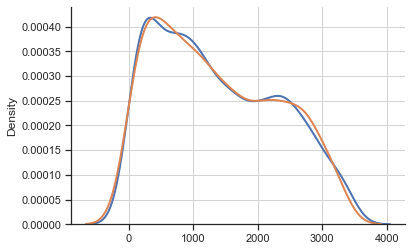

In [211]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
X, y, features, categ, sch_nan = ds.load_smarto_dataset()
# X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

In [7]:
# # importing libraries
# import os
# import psutil

# # inner psutil function
# def process_memory():
#     process = psutil.Process(os.getpid())
#     mem_info = process.memory_info()
#     return mem_info.rss

# # decorator function
# def profile(func):
#     def wrapper(*args, **kwargs):

#         mem_before = process_memory()
#         result = func(*args, **kwargs)
#         mem_after = process_memory()
#         print("{}:consumed memory: {:,}".format(
#             func.__name__,
#             mem_before, mem_after, mem_after - mem_before))

#         return result
#     return wrapper

# # instantiation of decorator function
# @profile
# # main code for which
# # memory has to be monitored
# def train_model():
#     tree = CRAID(**p)
#     tree.fit(X_tr, y_tr)
# #     del tree

# train_model()

from memory_profiler import profile

# instantiating the decorator
def train_model():
    tree = CRAID(**p)
    tree.fit(X_tr, y_tr)
    del tree

train_model()

In [8]:
!scalene ./memory.py

Scalene currently only supports the `multiprocessing` library on Mac and Unix platforms.


In [27]:
from memory_profiler import memory_usage
from survivors.tree import CRAID
from survivors.ensemble import ParallelBootstrapCRAID, IBSCleverBoostingCRAID
import sys

p_bstr = {'aggreg_func': 'mean',
             'categ': categ, 'criterion': 'logrank', 
             'depth': 7, 'ens_metric_name': 'CI', 'l_reg': 0, 'leaf_model': 'base_zero_after', 
             'max_features': 0.3, 'min_samples_leaf': 0.01, 'n_estimators': 50, 
             'n_jobs': 10, 'size_sample': 0.6, 'weighted_tree': False}

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 10, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0, 'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 1, 'n_jobs': 1, 'n_jobs_loop': 1, 'signif': 1, 'woe': True}

X, y, features, categ, sch_nan = ds.load_smarto_dataset()

@profile
def train_model():
#     tree = CRAID(**p)
    tree = IBSCleverBoostingCRAID(**p_bstr)
    tree.fit(X, y)

mem_usage = memory_usage(train_model)
print(f"Memory usage: {max(mem_usage) - min(mem_usage)} MB")

ERROR: Could not find file C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_29324\2419477637.py
UNIQUE (0):1742, DIST: [2034  289]
UNIQUE (1):1731, DIST: [2086  237]
UNIQUE (2):1757, DIST: [2064  259]
UNIQUE (3):1769, DIST: [2023  300]
UNIQUE (4):1755, DIST: [2058  265]
UNIQUE (5):1769, DIST: [2082  241]
UNIQUE (6):1749, DIST: [2047  276]
UNIQUE (7):1745, DIST: [2033  290]
UNIQUE (8):1742, DIST: [2058  265]
UNIQUE (9):1743, DIST: [2070  253]
UNIQUE (10):1754, DIST: [2057  266]
UNIQUE (11):1730, DIST: [2077  246]
UNIQUE (12):1751, DIST: [2054  269]
UNIQUE (13):1738, DIST: [2034  289]
UNIQUE (14):1737, DIST: [2034  289]
UNIQUE (15):1771, DIST: [2047  276]
UNIQUE (16):1730, DIST: [2057  266]
UNIQUE (17):1716, DIST: [2059  264]
UNIQUE (18):1756, DIST: [2028  295]
UNIQUE (19):1745, DIST: [2048  275]
UNIQUE (20):1739, DIST: [2061  262]
UNIQUE (21):1753, DIST: [2046  277]
UNIQUE (22):1749, DIST: [2046  277]
UNIQUE (23):1748, DIST: [2021  302]
UNIQUE (24):1737, DIST: [2064  259]
UNIQUE (25):17

In [10]:
from memory_profiler import profile
@profile
def train_model():
    tree = CRAID(**p)
    tree.fit(X_tr, y_tr)
    
train_model()

ERROR: Could not find file C:\Users\vasiliev\AppData\Local\Temp\4\ipykernel_29324\3353224138.py


1 9.761610984802246 9.761610984802246
2 2.4886155128479004 2.4886155128479004
5 2.4384820461273193 2.4384820461273193
10 2.407399892807007 2.407399892807007
20 2.4073994159698486 2.4073994159698486
30 2.384338140487671 2.384338140487671


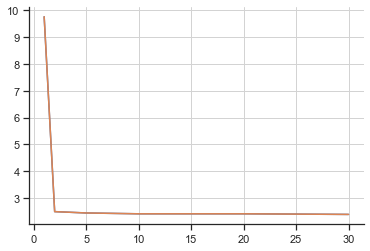

In [9]:
from survivors.ensemble import ParallelBootstrapCRAID
from survivors.tree import CRAID

param_bstr = {'aggreg_func': 'mean',
             'categ': categ, 'criterion': 'logrank', 
             'depth': 7, 'ens_metric_name': 'CI', 'l_reg': 0, 'leaf_model': 'base_zero_after', 
             'max_features': 0.3, 'min_samples_leaf': 0.01, 'n_estimators': 50, 
             'n_jobs': 20, 'size_sample': 0.6, 'weighted_tree': False}

p = {'balance': None, 'categ': categ, 'criterion': 'wilcoxon', 'cut': False, 'depth': 15, 
     'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.0, 'leaf_model': 'base_zero_after', 
     'max_features': 0.9, 'min_samples_leaf': 0.01, 'n_jobs': 20, 'n_jobs_loop': 1, 'signif': 1, 'woe': True}

n_js = [1, 2, 5, 10, 20, 30]
# n_js = [1, 2, 4, 8, 16, 32]
ft_s = []
t_s = []
for n_j in n_js:
    param_bstr['n_jobs'] = n_j
#     p['n_jobs'] = n_j
    
    time_start = time.time()
#     bstr = ParallelBootstrapCRAID(**param_bstr)
#     bstr.fit(X_tr, y_tr)
    
    tree = CRAID(**p)
    tree.fit(X_tr, y_tr)
    t_s.append(time.time() - time_start)
    
#     ens_metr_arr = bstr.tolerance_find_best(param_bstr["ens_metric_name"])
    ens_metr_arr = tree.tolerance_find_best(p["ens_metric_name"])
    
    ft_s.append(time.time() - time_start)
    print(n_j, t_s[-1], ft_s[-1])
    
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.show()
# auprc_by_obs_HO = metr.auprc(y_tr, y_HO, bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
# ibsrm_by_obs_HO = metr.ibs_remain(y_tr, y_HO, bstr.predict_at_times(X_HO, bins=bins_HO, mode="surv"), bins_HO, axis=0)
# print(auprc_by_obs_HO)
# print(ibsrm_by_obs_HO)

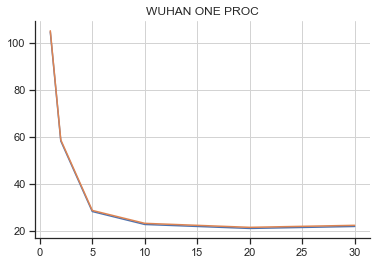

In [8]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("WUHAN ONE PROC")
plt.show()

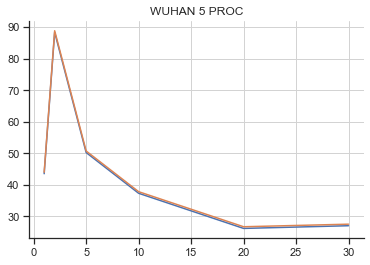

In [6]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("WUHAN 5 PROC")
plt.show()

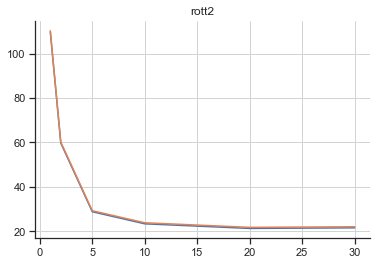

In [52]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("rott2")
plt.show()

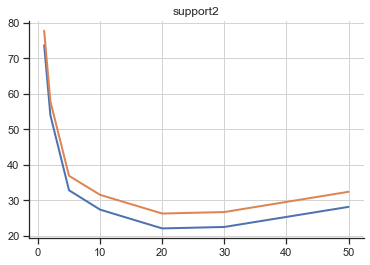

In [18]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("support2")
plt.show()

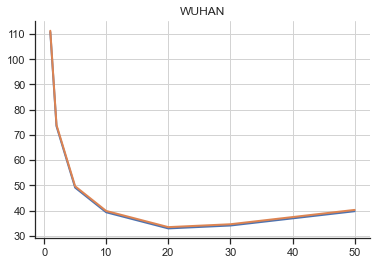

In [15]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("WUHAN")
plt.show()

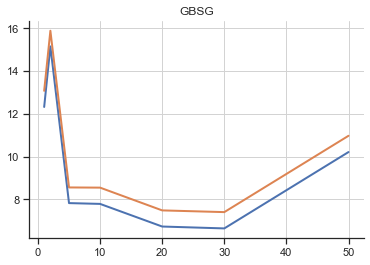

In [12]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("GBSG")
plt.show()

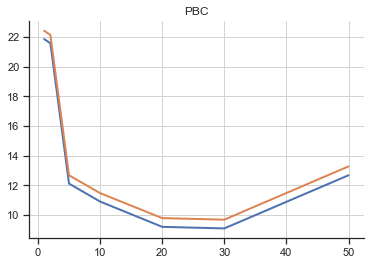

In [9]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("PBC")
plt.show()

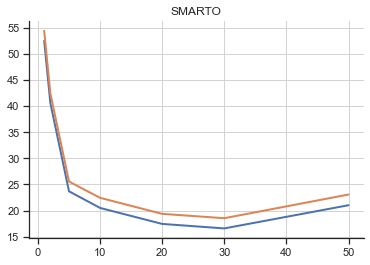

In [6]:
plt.plot(n_js, t_s)
plt.plot(n_js, ft_s)
plt.title("SMARTO")
plt.show()

In [118]:
group = "EQ_REG"
glob_dir_new = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/phd_normal_res_new_with_jit"
glob_dir = glob_dir_new

In [56]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

STAT_m = ['BaseLeafModeLL', "CoxPH", 'LogLogisticAFT', 'LogNormalAFT', "WeibullAFT"]
ML_m = ['ST', 'RSF', 'CWGBSA', 'GBSA']
NN_m = ['DeepSurv', 'CoxTime']
SELF_m = ['TREE_KMWV', 'BSTR', 'BOOST_linear', 'BOOST_exp', 'BOOST_sigmoid']

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
#     if len(s) > 0:
# #         return fr"${m}(\lambda={s})$"
#         return fr"${m}({cr})$"
    return m # fr"${m}$"

def find_best_index(df):
    ens_name = "IBS_REMAIN"
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
    column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_TREE_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + "_KMWV"
        dfs.append(df_sc)

        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_exp_PART_BOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + "_exp"
        dfs.append(df_sc)
        
#         datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_sigmoid_PART_BOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
#         df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
#         df_sc["METHOD"] = df_sc["METHOD"] + "_sigmoid"
#         dfs.append(df_sc)
        
        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_linear_PART_BOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"] + "_linear"
        dfs.append(df_sc)
        

        datasets_sc = f"{c_m}_STRATTIME+_EXT10_NORMAL_{group}_CLEVERBOOST_ALL_BINS_origin_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = "BSTR" # df_sc["METHOD"] #+ "_norm"
        dfs.append(df_sc)

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]  # , "LOGLIKELIHOOD"]  # BAL_AUPRC
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    
    df["METHOD"] = df.apply(define_name, axis=1)  # "(" + df["ens_metric_name"] + ")"
    df = df[~df["METHOD"].isin(["KM", "coxccCRAID", 'BaseLeafModeLL_ext', '$WeibullAFT$', '$LogLogisticAFT$'])]
    df = df[~df["METHOD"].isin(["$KM_{NEW}$", '$WeibullAFT_{NEW}$', '$LogLogisticAFT_{NEW}$'])]
    df = df.loc[df.groupby('METHOD')["IBS_REMAIN_CV_mean"].idxmin()]
    df["METHOD"] = df["METHOD"].astype("category")
    df["METHOD"] = df["METHOD"].cat.set_categories(SELF_m)
    
    df["TIME"] = df["TIME"] / 20
    
#     sns.barplot(df, x="island", y="body_mass_g", hue="sex")
#     df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
#     f, axes = plt.subplots(1, 4, figsize=(21, 4))
#     l_df = []
#     for i, v in enumerate(tg_metrs_1):
#         df[new_metrs[i]] = df[tg_metrs_1[i]]
#         v = new_metrs[i]
#         df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
#         explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
#         #l_df.append(explode_res.groupby(by="METHOD").mean().astype(str) + " +- " + explode_res.groupby(by="METHOD").std().astype(str))
#         l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.3f}+-{x.std():.3f}"))
#         axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
#         axes[i].set_ylabel(v)
#         axes[i].set_title("")
#     res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
#     res_table.index = list(map(lambda x: x.replace("\lambda",'l'), res_table.index))
#     res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
#     res_table.index = "$" + res_table.index + "$"
    
#     print(res_table)
#     return res_table.apply(rank_values) # df
    return df

ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["GBSG", "PBC", "rott2", "WUHAN", "smarto", "support2"]: # , "WUHAN", "rott2", "GBSG", "PBC", "smarto", "support2"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, group, ch_metrs)
    df["DATASET"] = ds
    df_l.append(df)

========== GBSG ==========
========== PBC ==========
========== rott2 ==========
========== WUHAN ==========
========== smarto ==========
========== support2 ==========


<Axes: xlabel='DATASET', ylabel='TIME'>

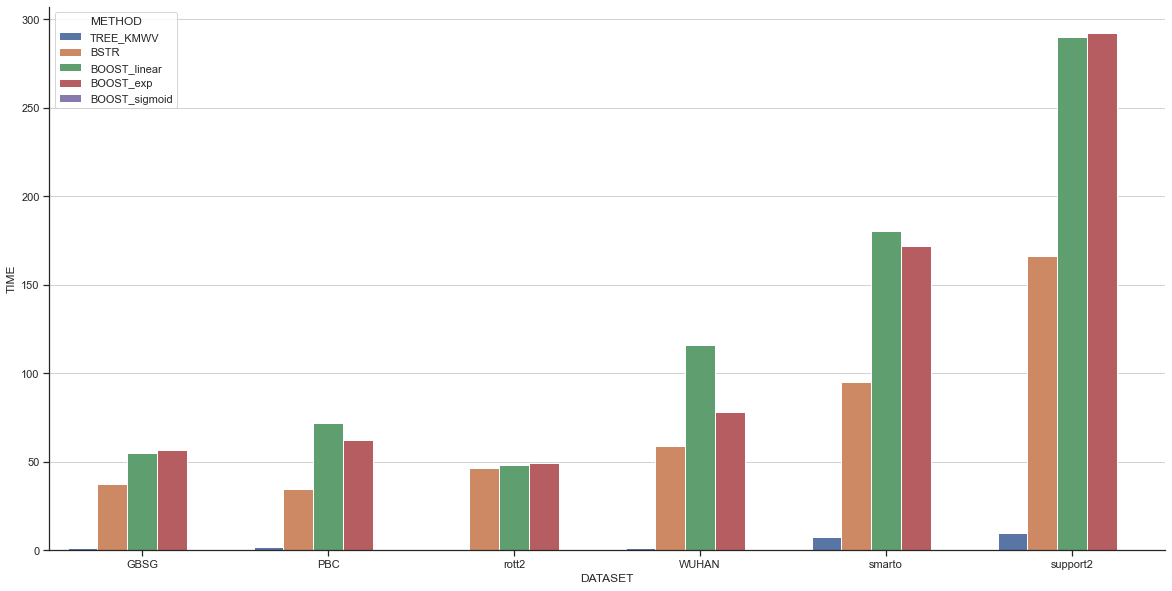

In [57]:
plt.figure(figsize=(20,10))
sns.barplot(pd.concat(df_l), x="DATASET", y="TIME", hue="METHOD")

In [232]:
group = "EQ_REG"
# glob_dir_ = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/phd_normal_res_new_with_jit"
# glob_dir_ = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/phd_normal_res_with_jit"
glob_dir_ = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/test_performance"
glob_dir = glob_dir_

METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

STAT_m = ['BaseLeafModeLL', "CoxPH", 'LogLogisticAFT', 'LogNormalAFT', "WeibullAFT"]
ML_m = ['ST', 'RSF', 'CWGBSA', 'GBSA']
NN_m = ['DeepSurv', 'CoxTime']
SELF_m = ['TREE', 'TREE_KMWV', 'BSTR', 'BOOST'] # , 'BOOST_exp', 'BOOST_sigmoid']

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
#     if len(s) > 0:
# #         return fr"${m}(\lambda={s})$"
#         return fr"${m}({cr})$"
    return m # fr"${m}$"

def find_best_index(df):
    ens_name = "IBS_REMAIN"
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
    column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:
        datasets_sc = f"{c_m}_TREE_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
#         df_sc["METHOD"] = df_sc["METHOD"] + "_KMWV"
        dfs.append(df_sc)
    
    
#         datasets_sc = f"{c_m}_STRAT_TREE_EXTRA_MEAN_{dataset}_CV+SAMPLE_best.xlsx"
#         df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
# #         df_sc["METHOD"] = df_sc["METHOD"] + "_KMWV"
#         dfs.append(df_sc)
        
#         datasets_sc = f"{c_m}_STRAT_TREE_EXTRA_{dataset}_CV+SAMPLE_best.xlsx"
#         df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
# #         df_sc["METHOD"] = df_sc["METHOD"] + "_KMWV"
#         dfs.append(df_sc)
        
#         datasets_sc = f"{c_m}_BOOST_linear_{dataset}_CV+SAMPLE_best.xlsx"
#         df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
# #         df_sc["METHOD"] = df_sc["METHOD"] + '_linear'
#         dfs.append(df_sc)
        
#         datasets_sc = f"{c_m}_STRAT_PARBSTR_{dataset}_CV+SAMPLE_best.xlsx"
#         df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
#         df_sc["METHOD"] = "BSTR" # df_sc["METHOD"] #+ "_norm"
#         dfs.append(df_sc)
        
        datasets_sc = f"{c_m}_PARBSTR_{dataset}_CV+SAMPLE_best.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = "BSTR" # df_sc["METHOD"] #+ "_norm"
        dfs.append(df_sc)
        
#         datasets_sc = f"likelihood_STRATTIME+_scsurv_{dataset}_CV+SAMPLE_best.xlsx"  # scsurv models
#         df_sc = pd.read_excel(os.path.join(os.path.split(glob_dir)[0], "many_ds", datasets_sc))
#         df_sc["METHOD"] = df_sc["METHOD"] + "_ext_no_sc"
#         dfs.append(df_sc)
# #         dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))

#         datasets_sc = f"LOGLIKELIHOOD_STRATTIME+_scsurv_extended_no_scale_{dataset}_CV+SAMPLE_best.xlsx"  # scsurv models
#         df_sc = pd.read_excel(os.path.join(os.path.split(glob_dir)[0], "many_ds", datasets_sc))
#         df_sc["METHOD"] = df_sc["METHOD"] + "_ext_no_sc"
#         dfs.append(df_sc)
# #         dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))
        
#         datasets_sc = f"extra_datasets_experiments_{dataset}_CV+SAMPLE_best.xlsx"
#         dfs.append(pd.read_excel(os.path.join(os.path.split(glob_dir)[0], "PyCox", datasets_sc)))
        

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]  # , "LOGLIKELIHOOD"]  # BAL_AUPRC
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    
    df["METHOD"] = df.apply(define_name, axis=1)  # "(" + df["ens_metric_name"] + ")"
    df = df[~df["METHOD"].isin(["KM", "coxccCRAID", 'BaseLeafModeLL_ext', '$WeibullAFT$', '$LogLogisticAFT$'])]
    df = df[~df["METHOD"].isin(["$KM_{NEW}$", '$WeibullAFT_{NEW}$', '$LogLogisticAFT_{NEW}$'])]
    df = df.loc[df.groupby('METHOD')["IBS_REMAIN_CV_mean"].idxmin()]
#     df["METHOD"] = df["METHOD"].astype("category")
#     df["METHOD"] = df["METHOD"].cat.set_categories(SELF_m)
    
#     df["METHOD"] = df["METHOD"].astype("category")
#     df["METHOD"] = df["METHOD"].cat.set_categories(STAT_m + ML_m + NN_m + SELF_m)
    
# #     df = df.loc[df.groupby('METHOD').apply(find_best_index).sum()]
    
#     f, axes = plt.subplots(1, 4, figsize=(21, 4))
#     l_df = []
# #     print(df[["TIME", "METHOD"]].groupby(by="METHOD").min())
#     for i, v in enumerate(tg_metrs_1):
# #         df[new_metrs[i]] = df[tg_metrs[i]]
# #         sns.boxplot(data=df, x="METHOD", y=new_metrs[i], palette='deep', ax=axes[i])
# #         df.boxplot(x="METHOD", y=new_metrs[i], ax=axes[i])
# #         axes[i].tick_params(axis='x', rotation=45)
#         df[new_metrs[i]] = df[tg_metrs_1[i]]
#         v = new_metrs[i]
#         df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
#         explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
#         #l_df.append(explode_res.groupby(by="METHOD").mean().astype(str) + " +- " + explode_res.groupby(by="METHOD").std().astype(str))
#         l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.3f}+-{x.std():.3f}"))
#         axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
#         axes[i].set_ylabel(v)
#         axes[i].set_title("")
#     res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
#     res_table.index = list(map(lambda x: x.replace("\lambda",'l'), res_table.index))
#     res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
#     res_table.index = "$" + res_table.index + "$"
    
#     print(res_table)
#     res_table_star = res_table.copy()
#     res_table_star = res_table_star.apply(add_star_top3)
#     res_table_star.to_csv(os.path.join(glob_dir, f"{dataset}_agg.csv"), sep="&")
#     plt.suptitle("")
#     plt.show()
#     return res_table.apply(rank_values) # df

    df["TIME"] = df["TIME"] / 20
    df["MEM"] = df["MEM"] / 20
    return df

ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["GBSG", "PBC", "rott2", "WUHAN", "smarto", "support2"]: # , "WUHAN", "rott2", "GBSG", "PBC", "smarto", "support2"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, group, ch_metrs)
    df["DATASET"] = ds
    df_l.append(df)

========== GBSG ==========
========== PBC ==========
========== rott2 ==========
========== WUHAN ==========
========== smarto ==========
========== support2 ==========


In [236]:
df_sh[df_sh["DATASET"] == "WUHAN"]["MEM"]

11    38.775
7      0.000
Name: MEM, dtype: float64

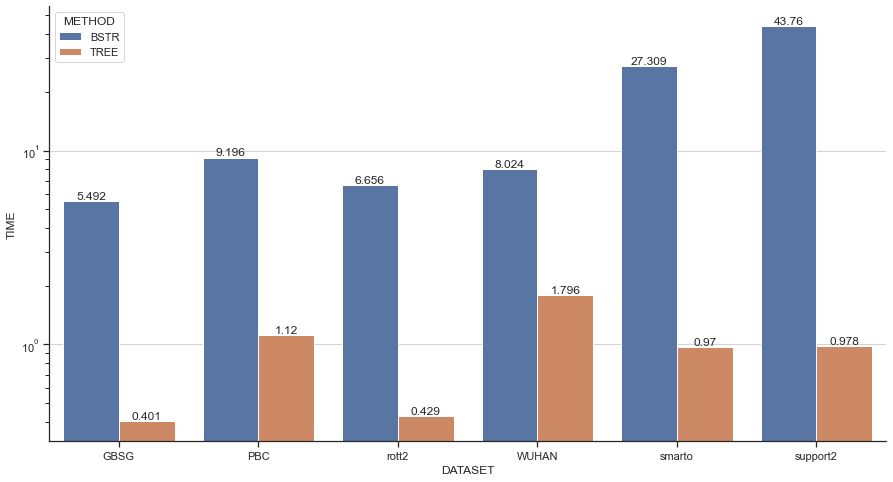

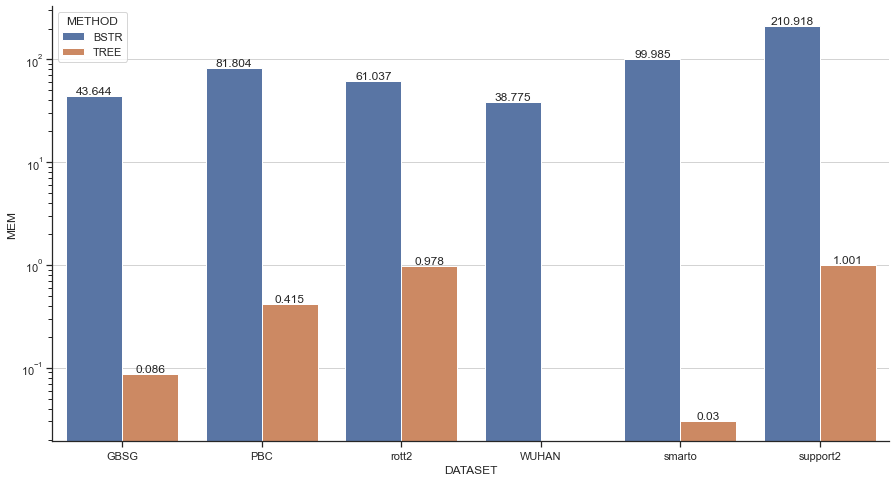

In [233]:
for f in ["TIME", "MEM"]:
    df_sh = pd.concat(df_l)
    df_sh[f] = df_sh[f].round(3)
    plt.figure(figsize=(15,8))
    ax = sns.barplot(df_sh, x="DATASET", y=f, hue="METHOD", estimator="sum")

    for ax_c in ax.containers:
        ax.bar_label(ax_c, fontsize=12)
    plt.yscale('log')
    plt.show()

In [214]:
print(memory_usage())
tree = CRAID(**p)
tree.fit(X_tr, y_tr)
print(memory_usage())
pred_sf = tree.predict_at_times(X_tr, bins=bins_HO, mode="surv")
pred_sf[:, -1] = 0
pred_sf[:, 0] = 1
pred_time = tree.predict(X_tr, target=cnt.TIME_NAME)
pred_hf = tree.predict_at_times(X_tr, bins=bins_HO, mode="hazard")
print(memory_usage())

[821.6015625]
[822.41015625]
[822.41015625]


In [213]:
del tree

In [202]:
pd.pivot_table(df_sh, values=['TIME', "MEM"], index=['DATASET'],
                      columns=['METHOD'], aggfunc="sum")

MEM             TIME          
METHOD     BSTR   TREE      BSTR      TREE
DATASET                                   
GBSG     58.746  0.051  5.434273  0.403900
PBC      66.256  0.063  8.866325  1.123320
WUHAN    33.852  0.004  8.997215  1.822344
rott2    65.932  1.033  6.510605  0.428811

In [190]:
df_sh = pd.concat(df_l)
d_best_hyper = {}
for n, g in df_sh.groupby("METHOD"):
    d_best_hyper[n] = dict()
    print(n)
    vals = [eval(d) for d in g["PARAMS"].values]
#     print(vals)
    for k in vals[0].keys():
        if k != "categ":
            d_best_hyper[n][k] = list(set([v[k] for v in vals]))
d_best_hyper

TREE_KMWV
[{'balance': None, 'categ': ['htreat', 'menostat', 'tumgrad'], 'criterion': 'wilcoxon', 'cut': False, 'depth': 15, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.9, 'leaf_model': 'base_zero_after', 'max_features': 1.0, 'min_samples_leaf': 0.05, 'n_jobs': 10, 'signif': 0.1, 'woe': True}, {'balance': None, 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'], 'criterion': 'wilcoxon', 'cut': False, 'depth': 15, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.9, 'leaf_model': 'base_zero_after', 'max_features': 1.0, 'min_samples_leaf': 0.05, 'n_jobs': 10, 'signif': 0.1, 'woe': True}, {'balance': None, 'categ': ['fac_meno', 'fac_tsize', 'fac_grade', 'fac_hormon', 'fac_chemo', 'fac_recent'], 'criterion': 'wilcoxon', 'cut': False, 'depth': 15, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0, 'leaf_model': 'base_zero_after', 'max_features': 1.0, 'min_samples_leaf': 0.05, 'n_jobs': 10, 'signif': 1.0, 'woe': True}, {'balance': None, 'categ': [], 'criterion': 'logrank', 'cut': False, 'depth': 15

{'TREE_KMWV': {'balance': [None],
  'criterion': ['wilcoxon', 'tarone-ware', 'logrank'],
  'cut': [False],
  'depth': [15],
  'ens_metric_name': ['IBS_REMAIN'],
  'l_reg': [0.9, 0, 0.1, 0.01],
  'leaf_model': ['base_zero_after'],
  'max_features': [1.0],
  'min_samples_leaf': [0.05, 0.01],
  'n_jobs': [10],
  'signif': [0.1, 1.0, 0.05],
  'woe': [True]}}

In [151]:
for index, row in df_sh.iterrows():
    print(row["METHOD"], row["PARAMS"], row["DATASET"])

BOOST {'aggreg_func': 'mean', 'all_weight': False, 'balance': None, 'categ': ['htreat', 'menostat', 'tumgrad'], 'criterion': 'wilcoxon', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0, 'leaf_model': 'base_zero_after', 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'mode_wei': 'linear', 'n_estimators': 50, 'size_sample': 0.5, 'weighted_tree': False, 'with_arc': False} GBSG
BSTR {'aggreg_func': 'mean', 'balance': None, 'categ': ['htreat', 'menostat', 'tumgrad'], 'criterion': 'peto', 'depth': 7, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.01, 'leaf_model': 'base_zero_after', 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'mode_wei': None, 'n_estimators': 50, 'n_jobs': 20, 'size_sample': 0.3} GBSG
TREE {'balance': None, 'categ': ['htreat', 'menostat', 'tumgrad'], 'criterion': 'logrank', 'cut': False, 'depth': 10, 'ens_metric_name': 'IBS_REMAIN', 'l_reg': 0.1, 'leaf_model': 'base_zero_after', 'max_features': 1.0, 'min_samples_leaf': 0.05, 'mode_wei': None, 'signif': 0.05, 'wo